# Notebook on research put-call parity

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', 500)
import seaborn as sns
import plotly.graph_objects as go
import datetime

In [2]:
df = pd.read_csv(f"./datasets/deribit_options_chain_2022-12-01_OPTIONS.csv")
data = df.copy()

## Отбираем нужные колонки и опционы только на одну криптовалюту

In [65]:
def preprocess_data(df: pd.DataFrame, currency: str  = "BTC"):
    ind = [symbol.startswith(currency) for symbol in df.symbol]
    needed_columns = ["timestamp", "type", "strike_price", "expiration", "mark_price", "underlying_price"]
    data = df[ind].reset_index(drop=True)[needed_columns]
    data["human_expiration"] = data["expiration"]\
    .apply(lambda x : datetime.datetime.fromtimestamp(x/1000000.0).strftime('%Y-%m-%d %H:%M:%S.%f'))
    data["human_timestamp"] = data["timestamp"]\
    .apply(lambda x : datetime.datetime.fromtimestamp(x/1000000.0).strftime('%Y-%m-%d %H:%M:%S.%f'))
    return data

In [66]:
single_currency_chain = preprocess_data(data)

In [69]:
single_currency_chain

,timestamp,type,strike_price,expiration,mark_price,underlying_price,human_expiration,human_timestamp
0,1669852800273000,put,17250,1669881600000000,0.0095,17165.5125,2022-12-01 11:00:00.000000,2022-12-01 03:00:00.273000
1,1669852800273000,call,17500,1671177600000000,0.0377,17162.3600,2022-12-16 11:00:00.000000,2022-12-01 03:00:00.273000
2,1669852800302000,call,16500,1669881600000000,0.0393,17165.5125,2022-12-01 11:00:00.000000,2022-12-01 03:00:00.302000
3,1669852800324000,call,16500,1669881600000000,0.0393,17165.5125,2022-12-01 11:00:00.000000,2022-12-01 03:00:00.324000
4,1669852800402000,put,250000,1672387200000000,13.5643,17164.6600,2022-12-30 11:00:00.000000,2022-12-01 03:00:00.402000
...,...,...,...,...,...,...,...,...
10432075,1669939199983000,call,34000,1672387200000000,0.0004,16953.1600,2022-12-30 11:00:00.000000,2022-12-02 02:59:59.983000
10432076,1669939199983000,call,10000,1695974400000000,0.4728,16962.0900,2023-09-29 11:00:00.000000,2022-12-02 02:59:59.983000
10432077,1669939199984000,call,5000,1680249600000000,0.7089,16946.2200,2023-03-31 11:00:00.000000,2022-12-02 02:59:59.984000
10432078,1669939199988000,call,13500,1670572800000000,0.2059,16975.1700,2022-12-09 11:00:00.000000,2022-12-02 02:59:59.988000


In [85]:
def plot_single_expiration(df: pd.DataFrame, strike_given: int = False, expiration_date_given: int = False)->None:
    single_expiration_date = df.sample(1).iloc[0]["expiration"]
    single_expiration_date = expiration_date_given if expiration_date_given else single_expiration_date
    single_expiration_df = df[df["expiration"] == single_expiration_date].copy()
    single_strike = single_expiration_df.sample(1).iloc[0]["strike_price"]
    single_strike = strike_given if strike_given else single_strike
    single_strike_df = single_expiration_df[single_expiration_df["strike_price"] == single_strike].copy()
    
    calls = single_strike_df[single_strike_df["type"] == "call"]
    puts = single_strike_df[single_strike_df["type"] == "put"]
    calls = calls.rename(columns = {"mark_price": "call_price"})[["timestamp", "call_price", 
        "strike_price", "underlying_price", "human_timestamp"]].copy()
    puts = puts.rename(columns = {"mark_price": "put_price"})[["timestamp", "put_price"]].copy()
    result = calls.merge(puts, on = "timestamp")
    return result


In [87]:
aaa = plot_single_expiration(single_currency_chain, strike_given=10000, expiration_date_given = 1695974400000000)
aaa["call_price_usd"] = aaa["call_price"] * aaa["underlying_price"]
aaa["put_price_usd"] = aaa["put_price"] * aaa["underlying_price"]

In [88]:
aaa

,timestamp,call_price,strike_price,underlying_price,human_timestamp,put_price,call_price_usd,put_price_usd
0,1669853080459000,0.4794,10000,17190.53,2022-12-01 03:04:40.459000,0.0611,8241.140082,1050.341383
1,1669854630315000,0.4805,10000,17221.15,2022-12-01 03:30:30.315000,0.0611,8274.762575,1052.212265
2,1669854655492000,0.4804,10000,17217.68,2022-12-01 03:30:55.492000,0.0612,8271.373472,1053.722016
3,1669854897309000,0.4799,10000,17197.12,2022-12-01 03:34:57.309000,0.0614,8252.897888,1055.903168
4,1669855061527000,0.4796,10000,17190.30,2022-12-01 03:37:41.527000,0.0613,8244.467880,1053.765390
...,...,...,...,...,...,...,...,...
872,1669938756899000,0.4726,10000,16959.14,2022-12-02 02:52:36.899000,0.0623,8014.889564,1056.554422
873,1669938824373000,0.4726,10000,16960.03,2022-12-02 02:53:44.373000,0.0622,8015.310178,1054.913866
874,1669938861627000,0.4726,10000,16958.40,2022-12-02 02:54:21.627000,0.0623,8014.539840,1056.508320
875,1669939055982000,0.4726,10000,16959.95,2022-12-02 02:57:35.982000,0.0623,8015.272370,1056.604885


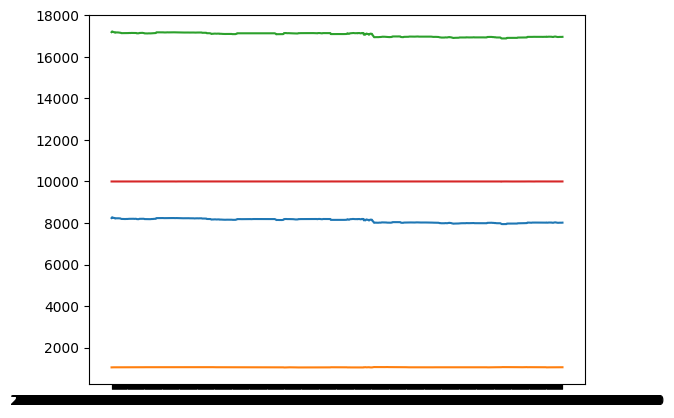

In [89]:
plt.plot(aaa["human_timestamp"], aaa["call_price_usd"])
plt.plot(aaa["human_timestamp"], aaa["put_price_usd"])
plt.plot(aaa["human_timestamp"], aaa["underlying_price"])
plt.plot(aaa["human_timestamp"], aaa["underlying_price"] - aaa["call_price_usd"] + aaa["put_price_usd"])
